In [43]:
import gymnasium
from gymnasium import error, spaces, utils, Env
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Descripción del problema

El siguiente ejemplo consiste en un Ambiente (Room). La temperatura de la habitación cambia debido a la temperatura externa ambiente (se asume de forma desconocida). La habitación cuenta con un equipo de Aire Acondicionado controlado por un Agente. El objetivo de este Agente es mantener la temperatura en 0 grados. El Aire Acondicionado puede cambiar la temperatura en 0, 1, 2 o 3 grados ya sea frío o calor.

# Ambiente

El ambiente (Room) está simulado por el siguiente código

In [44]:
class Room(Env):
    
    def __init__(self):
        self.observation_space = spaces.Box(low=-20, high=40, shape=(), dtype=np.float32)
        self.action_space = spaces.Discrete(7, start=-3)
                  
    def reset(self):
        self.step_count = 0
        self.initial_random = self.observation_space.sample()
        self.external_temp = 0
        self.external_temp = self._temp_variation()
        self.temp = self.external_temp
        return self.temp
    
    def step(self, action):
        delta_temp = self._temp_variation()
        self.external_temp += delta_temp
        self.temp += delta_temp + action
        self.step_count += 1
        return self.temp

    def _temp_variation(self):
        x = self.initial_random + self.step_count
        return np.float64('%.2f'%(20 * np.sin(x/10))) - self.external_temp 
          

# Test Room

In [45]:
env = Room()

In [46]:
env.observation_space

Box(-20.0, 40.0, (), float32)

In [47]:
env.observation_space.sample()

array(-16.723734, dtype=float32)

In [48]:
env.action_space

Discrete(7, start=-3)

In [49]:
env.action_space.sample()

np.int64(2)

In [50]:
env.reset()

np.float64(17.1)

# Reflex Agent

Esta es la implementación de un Agente Reflejo Simple, que dada la observación (temperatura de la habitación), toma una acción de enfriar o calentar en 0, 1, 2 o 3 grados. El agente solo enfría o calienta si la temperatura difiere en más de 2 grados.

In [51]:
class AgentReflex():

    def lookup(self, obs):
        if obs > 9:
            return -3
        elif obs > 5:
            return -2
        elif obs > 2:
            return -1
        elif obs < -9:
            return 3
        elif obs < -5:
            return 2
        elif obs < -2:
            return 1
        else:
            return 0

# Test Reflex

In [52]:
agent = AgentReflex()

In [53]:
obs = env.reset()
external_res = []
agent_res = []
total_steps = 100

In [54]:
for i in range(0, total_steps):  
    
    # solamente para evaluar la evolución de la temperatura de la habitación con y sin agente
    # la temperatura de la habitación sin el agente es igual a la temperatura exterior
    
    external_temp = env.external_temp
    external_res.append(external_temp)
    
    # decisión y acción del agente
    
    prev_obs = obs
    action = agent.lookup(obs)
    obs = env.step(action)
    agent_res.append(obs)  
    
    print('External:', external_temp, '\n','Prev. Obs:', prev_obs, '-> Action:', action, '-> Room:', obs)

External: 5.09 
 Prev. Obs: 5.09 -> Action: -2 -> Room: 3.09
External: 5.09 
 Prev. Obs: 3.09 -> Action: -1 -> Room: 3.99
External: 6.99 
 Prev. Obs: 3.99 -> Action: -1 -> Room: 4.83
External: 8.83 
 Prev. Obs: 4.83 -> Action: -1 -> Room: 5.58
External: 10.58 
 Prev. Obs: 5.58 -> Action: -2 -> Room: 5.220000000000001
External: 12.22 
 Prev. Obs: 5.220000000000001 -> Action: -2 -> Room: 4.74
External: 13.74 
 Prev. Obs: 4.74 -> Action: -1 -> Room: 5.119999999999999
External: 15.12 
 Prev. Obs: 5.119999999999999 -> Action: -2 -> Room: 4.350000000000001
External: 16.35 
 Prev. Obs: 4.350000000000001 -> Action: -1 -> Room: 4.420000000000002
External: 17.42 
 Prev. Obs: 4.420000000000002 -> Action: -1 -> Room: 4.309999999999999
External: 18.31 
 Prev. Obs: 4.309999999999999 -> Action: -1 -> Room: 4.02
External: 19.02 
 Prev. Obs: 4.02 -> Action: -1 -> Room: 3.5500000000000007
External: 19.55 
 Prev. Obs: 3.5500000000000007 -> Action: -1 -> Room: 2.870000000000001
External: 19.87 
 Prev. Obs

# Graficando los resultados

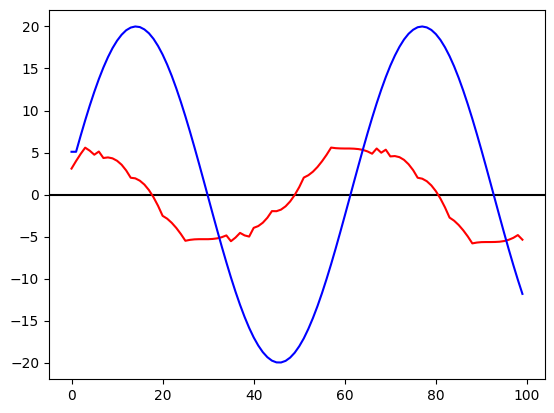

In [55]:
plt.axhline(color='black')                                  #Temperatura ideal
plt.plot(range(0, total_steps), agent_res, color='red')     #Temperatura con el agente
plt.plot(range(0, total_steps), external_res, color='blue') #Temperatura sin agente

# Métrica de Performance
Una posible métrica de performance, podría ser ver la temperatura media del ambiente con la acción del agente.

In [56]:
print("Temperatura media con el agente: ", np.mean(agent_res))
print("Temperatura media sin el agente: ", np.mean(external_res))

Temperatura media con el agente:  -0.21250000000000063
Temperatura media sin el agente:  3.562100000000001


Otra posible métrica de performance, es evaluar para cada instante de tiempo (step) cuanto difiere la temperatura obtenida de la objetivo=0. Esto se puede hacer con mean_squared_error o mean_absolute_error. 
Comparemos la métrica obtenida por el agente contra la métrica obtenida sin un agente:

In [57]:
goal_temp = np.zeros(total_steps)
print("Variación media con el agente: ", mean_absolute_error(goal_temp, agent_res))
print("Variación media sin el agente: ", mean_absolute_error(goal_temp, external_res))

Variación media con el agente:  3.892699999999999
Variación media sin el agente:  12.457300000000002


# Ejercicio: Model (Goal / Utility) Based Agent 

Construir un Agente basado en un modelo. 
Esto es: 
    - Construir un modelo a mano, por ejemplo un grafo, con estados y transiciones [Ver figura].
    - Discretizar las observaciones devueltas por el ambiente mapeándolas a un estado.
    - Tomar una decisón basada en el estado.
    - Definir un objetivo y una utilidad

Por ejemplo, el Agente podría conocer un modelo que tiene 2 estados {Frío, Calor}
<img src="Modelo.png">


# Model Based Agent

## Definicion de Estados

In [58]:
# Defino estados discretos
from enum import Enum

class State(Enum):
    FRIO_EXTREMO = "FRIO_EXTREMO"
    FRIO = "FRIO"
    OBJETIVO = "OBJETIVO"
    CALOR = "CALOR"
    CALOR_EXTREMO = "CALOR_EXTREMO"

# Rangos de temperatura para cada estado (ajustá según lo que te parezca)
STATE_RANGES = {
    State.FRIO_EXTREMO: (-float('inf'), -10),
    State.FRIO: (-10, -3),
    State.OBJETIVO: (-3, 3),
    State.CALOR: (3, 10),
    State.CALOR_EXTREMO: (10, float('inf'))
}

## Sensor

In [59]:
def sensor(temperatura):
    # mapea temperatura a estado
    for state, (low, high) in STATE_RANGES.items():
        if low < temperatura <= high:
            return state
    return None

## Modelo del mundo (Transiciones)

In [60]:
def transition_model(temperatura_actual, accion):
    # predice próximo estado
    temperatura_estimada = temperatura_actual + accion
    
    # uso el sensor para mapear la temperatura estimada al estado correspondiente
    estado_predicho = sensor(temperatura_estimada)
    
    return estado_predicho

## Funcion de utilidad

In [61]:
def utilidad_con_costo(temperatura_futura, accion):
    # Penalizar distancia a 0°C
    penalizacion_temp = -abs(temperatura_futura)
    
    # Penalizar acciones grandes (consumo energético)
    penalizacion_accion = -0.1 * abs(accion)
    
    return penalizacion_temp + penalizacion_accion

## Agente 

In [62]:
class ModelBasedAgent:
    
    def __init__(self):
        self.historial = []
        
    def decide(self, temperatura_observada):
        # Guardar historial
        self.historial.append(temperatura_observada)
        if len(self.historial) > 3:
            self.historial.pop(0)
        
        # Estimar tendencia
        if len(self.historial) >= 2:
            tendencia = self.historial[-1] - self.historial[-2]
        else:
            tendencia = 0
        
        mejor_accion = None
        mejor_utilidad = -float('inf')
        
        for accion in range(-3, 4):
            # Modelo sofisticado
            temperatura_futura = temperatura_observada + accion * 0.9 + tendencia * 0.4
            
            # Usar la función de utilidad
            util_total = utilidad_con_costo(temperatura_futura, accion)
            
            if util_total > mejor_utilidad:
                mejor_utilidad = util_total
                mejor_accion = accion
        
        return mejor_accion

## Test del Model Based Agent

In [63]:
agent = ModelBasedAgent()
obs = env.reset()
model_agent_res = []

for i in range(0, total_steps):  
    action = agent.decide(obs) # Este metodo es el que no usaba el reflex
    obs = env.step(action)
    model_agent_res.append(obs)

## Graficos comparatvos

# Test de ambos agentes


In [64]:
env = Room()
total_steps = 100

# Test Reflex Agent


In [65]:
agent_reflex = AgentReflex()
obs = env.reset()
external_res = []
reflex_res = []

for i in range(total_steps):
    external_temp = env.external_temp
    external_res.append(external_temp)
    
    action = agent_reflex.lookup(obs)
    obs = env.step(action)
    reflex_res.append(obs)

# Test Model-Based Agent (mismo ambiente inicial)

In [66]:
env2 = Room()
env2.initial_random = env.initial_random  # Mismo random seed para comparación justa
env2.reset()

agent_model = ModelBasedAgent()
obs = env2.reset()
model_res = []

for i in range(total_steps):
    action = agent_model.decide(obs)
    obs = env2.step(action)
    model_res.append(obs)

# Gráfico comparativo


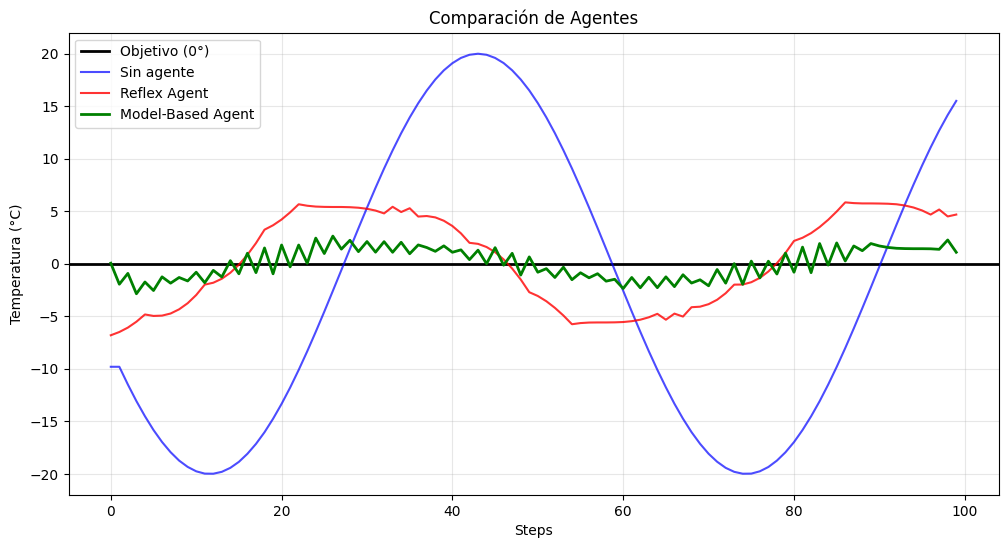

In [67]:
plt.figure(figsize=(12, 6))
plt.axhline(color='black', label='Objetivo (0°)', linewidth=2)
plt.plot(range(total_steps), external_res, color='blue', label='Sin agente', alpha=0.7)
plt.plot(range(total_steps), reflex_res, color='red', label='Reflex Agent', alpha=0.8)
plt.plot(range(total_steps), model_res, color='green', label='Model-Based Agent', linewidth=2)
plt.xlabel('Steps')
plt.ylabel('Temperatura (°C)')
plt.title('Comparación de Agentes')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Métricas de performance comparativas

In [68]:
goal_temp = np.zeros(total_steps)

print("=" * 50)
print("MÉTRICAS DE PERFORMANCE")
print("=" * 50)

print("\n1. Temperatura Media:")
print(f"   Sin agente:        {np.mean(external_res):.2f}°C")
print(f"   Reflex Agent:      {np.mean(reflex_res):.2f}°C")
print(f"   Model-Based Agent: {np.mean(model_res):.2f}°C")

print("\n2. Variación Media (MAE - menor es mejor):")
print(f"   Sin agente:        {mean_absolute_error(goal_temp, external_res):.2f}")
print(f"   Reflex Agent:      {mean_absolute_error(goal_temp, reflex_res):.2f}")
print(f"   Model-Based Agent: {mean_absolute_error(goal_temp, model_res):.2f}")

print("\n3. Desviación Estándar (menor es mejor):")
print(f"   Sin agente:        {np.std(external_res):.2f}")
print(f"   Reflex Agent:      {np.std(reflex_res):.2f}")
print(f"   Model-Based Agent: {np.std(model_res):.2f}")

print("\n4. Temperatura Máxima alcanzada:")
print(f"   Sin agente:        {np.max(np.abs(external_res)):.2f}°C")
print(f"   Reflex Agent:      {np.max(np.abs(reflex_res)):.2f}°C")
print(f"   Model-Based Agent: {np.max(np.abs(model_res)):.2f}°C")

print("=" * 50)

MÉTRICAS DE PERFORMANCE

1. Temperatura Media:
   Sin agente:        -3.07°C
   Reflex Agent:      0.38°C
   Model-Based Agent: 0.05°C

2. Variación Media (MAE - menor es mejor):
   Sin agente:        12.70
   Reflex Agent:      4.04
   Model-Based Agent: 1.31

3. Desviación Estándar (menor es mejor):
   Sin agente:        13.71
   Reflex Agent:      4.36
   Model-Based Agent: 1.46

4. Temperatura Máxima alcanzada:
   Sin agente:        20.00°C
   Reflex Agent:      6.80°C
   Model-Based Agent: 2.85°C
